In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler


# from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score,mean_squared_error

import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error

In [137]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [138]:
data = pd.read_csv("BodyFat.csv")
print(data.isnull().sum())
data.describe()

IDNO         0
BODYFAT      0
DENSITY      0
AGE          0
WEIGHT       0
HEIGHT       0
ADIPOSITY    0
NECK         0
CHEST        0
ABDOMEN      0
HIP          0
THIGH        0
KNEE         0
ANKLE        0
BICEPS       0
FOREARM      0
WRIST        0
dtype: int64


,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,126.500000,18.938492,1.055574,44.884921,178.924405,70.148810,25.436905,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,72.890329,7.750856,0.019031,12.602040,29.389160,3.662856,3.648111,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,1.000000,0.000000,0.995000,22.000000,118.500000,29.500000,18.100000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,63.750000,12.800000,1.041400,35.750000,159.000000,68.250000,23.100000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,126.500000,19.000000,1.054900,43.000000,176.500000,70.000000,25.050000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,189.250000,24.600000,1.070400,54.000000,197.000000,72.250000,27.325000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,252.000000,45.100000,1.108900,81.000000,363.150000,77.750000,48.900000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


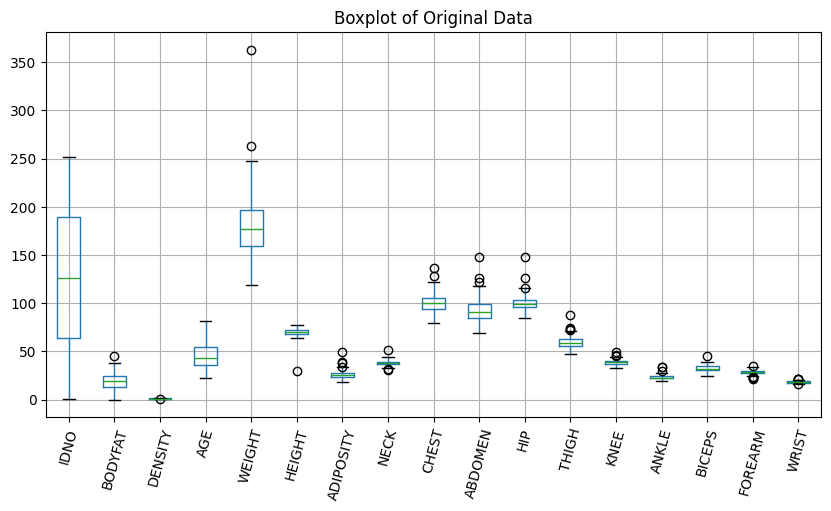

In [139]:
df = pd.DataFrame(data)
plt.figure(figsize=(10, 5))
df.boxplot()
plt.title('Boxplot of Original Data')
plt.xticks(rotation=75)
plt.show()



### Remove outliers

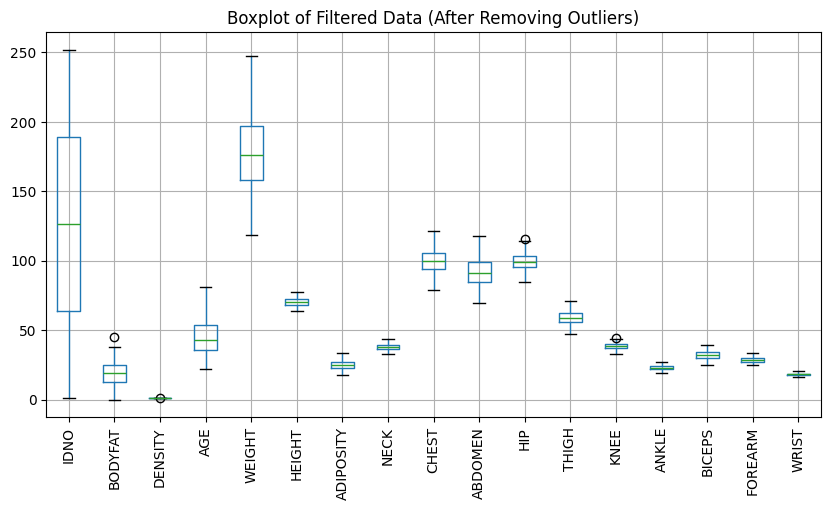

In [140]:
filtered_columns = [col for col in data.columns if col not in ["IDNO","BODYFAT","DENSITY","AGE"]]
df_removed = df.copy()
for column in filtered_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_removed[column] = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)][column]


plt.figure(figsize=(10, 5))
df_removed.boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot of Filtered Data (After Removing Outliers)')
plt.show()

In [141]:
df_removed.describe()
# X = df_removed.drop(columns=["IDNO","BODYFAT","DENSITY","ADIPOSITY"])
X = df_removed.drop(columns=["IDNO","BODYFAT","DENSITY"])
y = df_removed["BODYFAT"]
print("X missing data:\n",X.isnull().sum())
print("y missing data:\n",y.isnull().sum())

X missing data:
 AGE          0
WEIGHT       2
HEIGHT       1
ADIPOSITY    4
NECK         3
CHEST        2
ABDOMEN      3
HIP          3
THIGH        4
KNEE         3
ANKLE        3
BICEPS       1
FOREARM      5
WRIST        4
dtype: int64
y missing data:
 0


### K-fold searching for k

经高人指点，kfold的模型选取用knn模型预测，这样避免了特征选取的问题

In [142]:
pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer()),  
    ('model',KNeighborsRegressor())  
])

param_grid = {
    'imputer__n_neighbors': [ 3,5,7,9, 11, 13, 15, 17, 19, 21, 25]  
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
#kf = KFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print("Best n_neighbors:", grid_search.best_params_)

Best n_neighbors: {'imputer__n_neighbors': 3}


## Imputation

In [143]:
imputer = KNNImputer(n_neighbors=3)
df_imputed = pd.DataFrame(imputer.fit_transform(df_removed), columns=df_removed.columns)


# scaler = MinMaxScaler()
# scaler.fit(df_imputed)
# df_imputed_scaled = pd.DataFrame(scaler.transform(df_imputed),columns=df_imputed.columns)

# df_imputed_scaled.describe()

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
count,252.0000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.5000,0.419922,0.531816,0.387880,0.462939,0.459115,0.473232,0.466419,0.504947,0.470644,0.480653,0.501405,0.493894,0.493956,0.519999,0.448801,0.488957
std,0.2904,0.171859,0.167089,0.213594,0.206563,0.189767,0.207419,0.199652,0.189058,0.204646,0.206186,0.199080,0.201924,0.169818,0.204174,0.199276,0.201251
min,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.2500,0.283814,0.407375,0.233051,0.314563,0.309091,0.328947,0.324324,0.355792,0.312243,0.344262,0.366667,0.354911,0.367089,0.377622,0.293478,0.348837
50%,0.5000,0.421286,0.525900,0.355932,0.450485,0.445455,0.457237,0.468468,0.481087,0.443416,0.468852,0.491667,0.491071,0.468354,0.506993,0.451087,0.511628
75%,0.7500,0.545455,0.661984,0.542373,0.609709,0.600000,0.606908,0.594595,0.616430,0.615741,0.607377,0.631250,0.618304,0.620253,0.666084,0.586957,0.627907
max,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


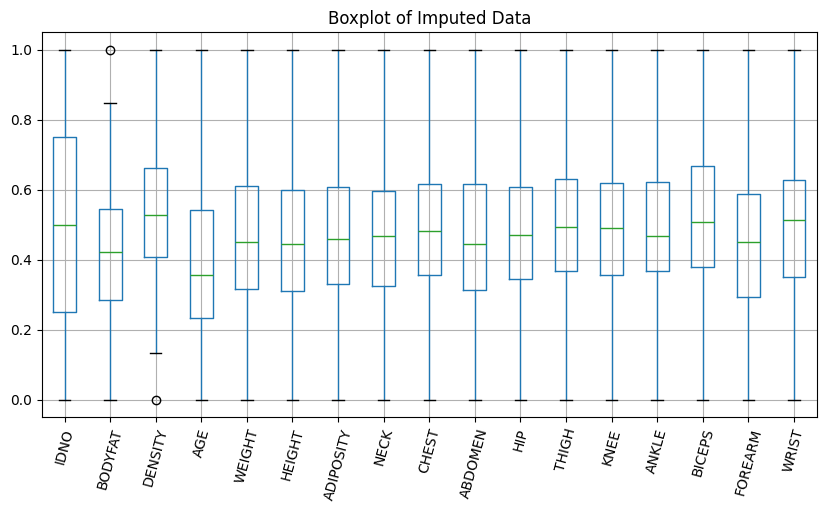

In [144]:
plt.figure(figsize=(10, 5))
df_imputed_scaled.boxplot()
plt.title('Boxplot of Imputed Data')
plt.xticks(rotation=75)
plt.show()

### Dealing with BMI calculating problem(not solved)

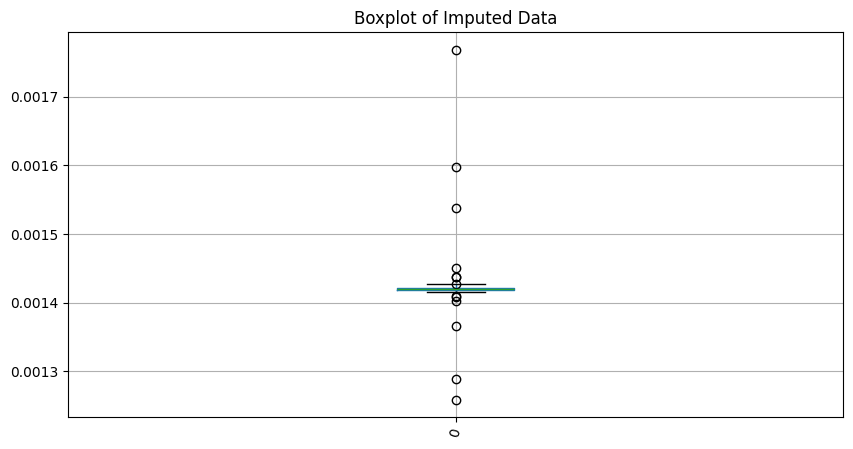

In [145]:
ratio = (df_imputed["WEIGHT"]/df_imputed["HEIGHT"]**2)/df_imputed["ADIPOSITY"]
pd.DataFrame(ratio).describe()
plt.figure(figsize=(10, 5))
pd.DataFrame(ratio).boxplot()
plt.title('Boxplot of Imputed Data')
plt.xticks(rotation=75)
plt.show()

$$ratio = \frac{\frac{Weight}{Height^2}}{bmi}$$
正常情况下这一列的取值应该保持一致，如果不是傻逼的英制单位这个值应该是1
$$1kg = 2.2046lb $$
$$1m = 39.3701in$$
$$\frac{1kg}{1m^2}=\frac{2.2046lb}{(39.3701in)^2}=0.001422\frac{lb}{in^2}$$
现在成0.001422左右了

In [146]:
ratio_df = pd.DataFrame(ratio)


outliers_index = []


for col in ratio_df.columns:
    Q1 = ratio_df[col].quantile(0.25)  
    Q3 = ratio_df[col].quantile(0.75)  
    IQR = Q3 - Q1  
    
    lower_bound = Q1 - 1.5 * IQR  
    upper_bound = Q3 + 1.5 * IQR  
    

    outliers = ratio_df[(ratio_df[col] < lower_bound) | (ratio_df[col] > upper_bound)].index
    outliers_index.extend(outliers.tolist()) 


outliers_index = sorted(set(outliers_index))  
print(f"All Outliers Index: {outliers_index}")

All Outliers Index: [38, 40, 41, 45, 60, 85, 115, 155, 162, 215, 220, 234, 241]


In [147]:
handle = df_imputed.iloc[outliers_index,:]
handle

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
38,39.0,33.8,1.0202,46.0,208.333333,72.250000,30.966667,39.033333,111.366667,107.866667,110.700000,66.533333,41.0,25.1,35.566667,29.0,18.033333
40,41.0,33.1,1.0217,45.0,210.666667,68.750000,30.733333,43.200000,111.566667,107.866667,107.533333,64.666667,39.6,26.6,36.400000,32.7,18.500000
41,42.0,31.7,1.0250,44.0,205.000000,70.833333,29.900000,36.600000,106.000000,104.300000,115.500000,70.600000,42.5,23.7,33.600000,28.7,17.400000
45,46.0,14.1,1.0670,43.0,164.250000,73.250000,21.300000,35.700000,96.600000,81.500000,97.200000,58.400000,38.2,23.4,29.700000,27.4,18.300000
60,61.0,25.4,1.0396,62.0,216.000000,73.250000,28.200000,41.400000,112.300000,104.800000,103.100000,61.600000,40.9,23.1,36.200000,31.8,20.200000
85,86.0,25.8,1.0386,67.0,167.000000,67.500000,26.000000,36.500000,98.900000,89.700000,96.200000,54.700000,37.8,23.7,32.400000,27.7,18.200000
115,116.0,16.7,1.0607,40.0,158.000000,69.250000,23.400000,36.300000,97.000000,86.600000,92.600000,55.900000,36.3,22.1,29.800000,26.3,17.300000
155,156.0,17.2,1.0594,28.0,171.500000,75.250000,21.600000,35.600000,92.100000,83.500000,98.300000,57.300000,37.8,21.7,32.200000,27.7,17.700000
162,163.0,13.3,1.0690,33.0,184.250000,68.750000,24.400000,40.700000,98.900000,92.100000,103.500000,64.000000,37.3,23.5,33.500000,30.6,19.700000
215,216.0,45.1,0.9950,51.0,219.000000,64.000000,30.233333,41.200000,119.800000,109.433333,112.800000,62.500000,36.9,23.6,34.700000,29.1,18.400000


In [148]:
mean_height = df_imputed['HEIGHT'].mean()
std_height = df_imputed['HEIGHT'].std()
mean_weight = df_imputed['WEIGHT'].mean()
std_weight =df_imputed['WEIGHT'].std()


handle['zscore_height'] = (handle['HEIGHT'] - mean_height) / std_height
handle['zscore_weight'] = (handle['WEIGHT'] - mean_weight) / std_weight
transform = 0.001422

def recalculate_values(row):
    if abs(row['zscore_height']) > abs(row['zscore_weight']):
        new_height = np.sqrt(row['WEIGHT'] / (row['ADIPOSITY']*transform))
        return new_height, row['WEIGHT']  
    else:
        new_weight = row['ADIPOSITY'] * (row['HEIGHT'] ** 2)*transform
        return row['HEIGHT'], new_weight  

handle = pd.DataFrame(handle)
handle[['new_height', 'new_weight']] = handle.apply(recalculate_values, axis=1, result_type='expand')

handle['HEIGHT'] = handle['new_height']
handle['WEIGHT'] = handle['new_weight']

handle.drop(columns=['zscore_height', 'zscore_weight', 'new_height', 'new_weight'], inplace=True)
handle

E:\新建文件夹 (2)\ipykernel_16432\1115884418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  handle['zscore_height'] = (handle['HEIGHT'] - mean_height) / std_height
E:\新建文件夹 (2)\ipykernel_16432\1115884418.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  handle['zscore_weight'] = (handle['WEIGHT'] - mean_weight) / std_weight


,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
38,39.0,33.8,1.0202,46.0,229.863364,72.250000,30.966667,39.033333,111.366667,107.866667,110.700000,66.533333,41.0,25.1,35.566667,29.0,18.033333
40,41.0,33.1,1.0217,45.0,206.564016,68.750000,30.733333,43.200000,111.566667,107.866667,107.533333,64.666667,39.6,26.6,36.400000,32.7,18.500000
41,42.0,31.7,1.0250,44.0,213.327156,70.833333,29.900000,36.600000,106.000000,104.300000,115.500000,70.600000,42.5,23.7,33.600000,28.7,17.400000
45,46.0,14.1,1.0670,43.0,164.250000,73.639883,21.300000,35.700000,96.600000,81.500000,97.200000,58.400000,38.2,23.4,29.700000,27.4,18.300000
60,61.0,25.4,1.0396,62.0,215.161202,73.250000,28.200000,41.400000,112.300000,104.800000,103.100000,61.600000,40.9,23.1,36.200000,31.8,20.200000
85,86.0,25.8,1.0386,67.0,167.000000,67.208123,26.000000,36.500000,98.900000,89.700000,96.200000,54.700000,37.8,23.7,32.400000,27.7,18.200000
115,116.0,16.7,1.0607,40.0,159.571383,69.250000,23.400000,36.300000,97.000000,86.600000,92.600000,55.900000,36.3,22.1,29.800000,26.3,17.300000
155,156.0,17.2,1.0594,28.0,171.500000,74.723187,21.600000,35.600000,92.100000,83.500000,98.300000,57.300000,37.8,21.7,32.200000,27.7,17.700000
162,163.0,13.3,1.0690,33.0,184.250000,72.871723,24.400000,40.700000,98.900000,92.100000,103.500000,64.000000,37.3,23.5,33.500000,30.6,19.700000
215,216.0,45.1,0.9950,51.0,219.000000,71.372226,30.233333,41.200000,119.800000,109.433333,112.800000,62.500000,36.9,23.6,34.700000,29.1,18.400000


In [149]:
df_imputed.set_index('IDNO', inplace=True)
handle.set_index('IDNO', inplace=True)

df_imputed.update(handle)

df_imputed.reset_index(inplace=True)
df_imputed

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,1.0,12.6,1.0708,23.0,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.100000
1,2.0,6.9,1.0853,22.0,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.200000
2,3.0,24.6,1.0414,22.0,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.600000
3,4.0,10.9,1.0751,26.0,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.200000
4,5.0,27.8,1.0340,24.0,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,248.0,11.5,1.0736,70.0,134.25,67.00,21.1,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.500000
248,249.0,32.3,1.0236,72.0,201.00,69.75,29.1,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.100000
249,250.0,28.3,1.0328,72.0,186.75,66.00,30.2,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.000000
250,251.0,25.3,1.0399,72.0,190.75,70.50,27.0,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.800000


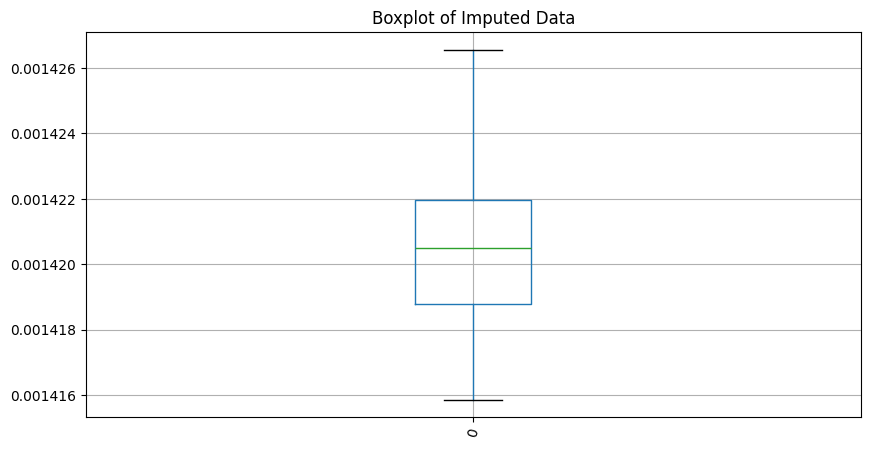

In [150]:
ratio = (df_imputed["WEIGHT"]/df_imputed["HEIGHT"]**2)/df_imputed["ADIPOSITY"]

plt.figure(figsize=(10, 5))
pd.DataFrame(ratio).boxplot()
plt.title('Boxplot of Imputed Data')
plt.xticks(rotation=75)
plt.show()

实际上这个比值离群点很多，要么是因为插值，要么是因为原本计算有误

In [151]:
# from mpl_toolkits.mplot3d import Axes3D


# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')


# ax.scatter(df_imputed['ABDOMEN'], df_imputed['WRIST'], df_imputed['BODYFAT'], color='blue')

# ax.set_xlabel('ABDOMEN')
# ax.set_ylabel('WRIST')
# ax.set_zlabel('BODYFAT')

# plt.title('3D Scatter Plot')
# plt.show()

In [152]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from mpl_toolkits.mplot3d import Axes3D


# X = df_imputed[['ABDOMEN', 'WRIST']]
# Y = df_imputed['BODYFAT']


# model = LinearRegression()
# model.fit(X, Y)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# ax.scatter(X['ABDOMEN'], X['WRIST'], Y,alpha=0.8, color='blue', label='Data Points')

# x1_range = np.linspace(X['ABDOMEN'].min(), X['ABDOMEN'].max(), 100)
# x2_range = np.linspace(X['WRIST'].min(), X['WRIST'].max(), 100)
# x1, x2 = np.meshgrid(x1_range, x2_range)

# X_grid = np.c_[x1.ravel(), x2.ravel()]
# y_pred = model.predict(X_grid)
# y_pred = y_pred.reshape(x1.shape)

# ax.plot_surface(x1, x2, y_pred, color='r', alpha=0.5, label='Regression Plane')

# ax.set_xlabel('ABDOMEN(cm)')
# ax.set_ylabel('WRIST(cm)')
# ax.set_zlabel('BODYFAT')


# scatter_proxy = plt.Line2D([0], [0], linestyle="none", color='blue', marker='o')
# surface_proxy = plt.Line2D([0], [0], linestyle="none", color='r', marker='s')
# ax.legend([scatter_proxy, surface_proxy], ['Actual Data', 'Predicted Regression Plane'])

# plt.title('3D Scatter Plot with Regression Plane')
# plt.show()



In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression



## Step-wise Selection

In [281]:
def forward_selection(X, y, significance_level=0.05):
    initial_features = []
    remaining_features = list(X.columns)
    while remaining_features:
        p_values = pd.Series(index=remaining_features, dtype=float)
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[initial_features + [feature]])).fit()
            p_values[feature] = model.pvalues[feature]
        min_p_value = p_values.min()
        if min_p_value < significance_level:
            best_feature = p_values.idxmin()
            initial_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
    return initial_features

In [282]:
def backward_selection(X, y, significance_level=0.05):
    features = list(X.columns) 
    while len(features) > 0:
        model = sm.OLS(y, X[features]).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            print(f"Removing {excluded_feature} with p-value {max_p_value}")
            features.remove(excluded_feature)
        else:
            break
    return features

In [283]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS

In [284]:
scaler = MinMaxScaler()
scaler.fit(df_imputed)
df_imputed_scaled = pd.DataFrame(scaler.transform(df_imputed),columns=df_imputed.columns)

df_imputed_scaled.describe()

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
count,252.0000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,0.5000,0.419922,0.531816,0.387880,0.463846,0.462408,0.473232,0.466419,0.504947,0.470644,0.480653,0.501405,0.493894,0.493956,0.519999,0.448801,0.488957
std,0.2904,0.171859,0.167089,0.213594,0.206578,0.187660,0.207419,0.199652,0.189058,0.204646,0.206186,0.199080,0.201924,0.169818,0.204174,0.199276,0.201251
min,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.2500,0.283814,0.407375,0.233051,0.318377,0.322727,0.328947,0.324324,0.355792,0.312243,0.344262,0.366667,0.354911,0.367089,0.377622,0.293478,0.348837
50%,0.5000,0.421286,0.525900,0.355932,0.450485,0.454545,0.457237,0.468468,0.481087,0.443416,0.468852,0.491667,0.491071,0.468354,0.506993,0.451087,0.511628
75%,0.7500,0.545455,0.661984,0.542373,0.609709,0.600000,0.606908,0.594595,0.616430,0.615741,0.607377,0.631250,0.618304,0.620253,0.666084,0.586957,0.627907
max,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [285]:
X_imputed = df_imputed.drop(columns=["IDNO","BODYFAT","DENSITY"])
y = df_imputed["BODYFAT"]

model = LinearRegression()

sfs = SFS(model, n_features_to_select='auto', direction='forward',cv=None)
sfs.fit(X_imputed , y)

selected_features = sfs.get_support()
# print("Selected features (by index):", selected_features)
X_selected = X_imputed.loc[:, selected_features]   

print("Selected features matrix:\n", X_selected.columns)

Selected features matrix:
 Index(['AGE', 'ADIPOSITY', 'NECK', 'ABDOMEN', 'THIGH', 'KNEE', 'WRIST'], dtype='object')


In [286]:
X_imputed_scaled = df_imputed_scaled.drop(columns=["IDNO","BODYFAT","DENSITY"])
y = df_imputed["BODYFAT"]

model = LinearRegression()

sfs = SFS(model, n_features_to_select='auto', direction='backward',cv=5)
sfs.fit(X_imputed_scaled , y)

selected_features = sfs.get_support()
# print("Selected features (by index):", selected_features)
X_selected = X_imputed_scaled.loc[:, selected_features]   

print("Selected features matrix:\n", X_selected.columns)

Selected features matrix:
 Index(['AGE', 'ADIPOSITY', 'NECK', 'ABDOMEN', 'THIGH', 'KNEE', 'WRIST'], dtype='object')


In [287]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [288]:
result_forward = forward_selection(X_imputed_scaled , y)
result_forward

['ABDOMEN', 'WRIST', 'HEIGHT', 'AGE']

In [289]:
result_backward = backward_selection(X_imputed_scaled , y)
result_backward

Removing HIP with p-value 0.7507340320207048
Removing FOREARM with p-value 0.7010262195142857
Removing CHEST with p-value 0.3865564999165454
Removing ANKLE with p-value 0.312967733684595
Removing BICEPS with p-value 0.3294846307891044
Removing NECK with p-value 0.20677357450834027
Removing KNEE with p-value 0.1393149538820548
Removing THIGH with p-value 0.10345898126426974
Removing AGE with p-value 0.05486661572675113


['WEIGHT', 'HEIGHT', 'ADIPOSITY', 'ABDOMEN', 'WRIST']

In [307]:
output_stepwise = stepwise_selection(X_imputed_scaled , y)
result_stepwise = output_stepwise
result_stepwise

Add  ABDOMEN                        with p-value 9.95145e-63
Add  WRIST                          with p-value 9.39905e-09
Add  HEIGHT                         with p-value 0.000415091
Add  AGE                            with p-value 0.0381838


['ABDOMEN', 'WRIST', 'HEIGHT', 'AGE']

In [291]:
from mlxtend.feature_selection import SequentialFeatureSelector

linreg = LinearRegression()

sfs = SequentialFeatureSelector(linreg, forward=True, k_features='best', scoring='r2', cv=5)
sfs.fit(X_imputed_scaled, y)

sfs.k_feature_names_

('AGE', 'ADIPOSITY', 'NECK', 'ABDOMEN', 'THIGH', 'KNEE', 'WRIST')

In [292]:
linreg = LinearRegression()

sfs = SequentialFeatureSelector(linreg, forward=False, k_features='best', scoring='r2', cv=None)
sfs.fit(X_imputed_scaled, y)

sfs.k_feature_names_

('AGE',
 'WEIGHT',
 'HEIGHT',
 'ADIPOSITY',
 'NECK',
 'CHEST',
 'ABDOMEN',
 'HIP',
 'THIGH',
 'KNEE',
 'ANKLE',
 'BICEPS',
 'FOREARM',
 'WRIST')

## Visualization

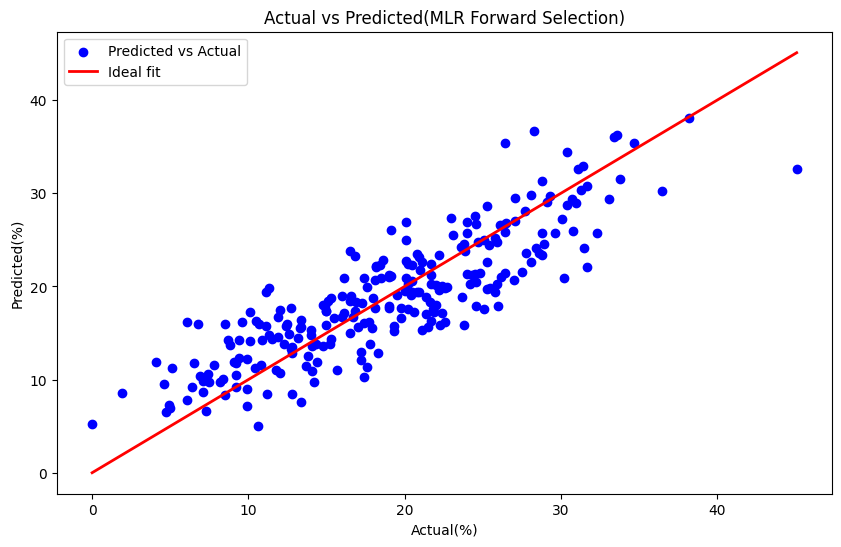

Mean Squared Error: 15.648020007466874


In [293]:
X_forward = X_selected
X_backward = X_selected
X_stepwise = X_imputed_scaled.loc[:, result] 

model = LinearRegression()

model.fit(X_forward,y)

y_pred = model.predict(X_selected)


plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Ideal fit')
plt.xlabel('Actual(%)')
plt.ylabel('Predicted(%)')
plt.title('Actual vs Predicted(MLR Forward Selection)')
plt.legend()

plt.show()


print("Mean Squared Error:", mean_squared_error(y, y_pred))

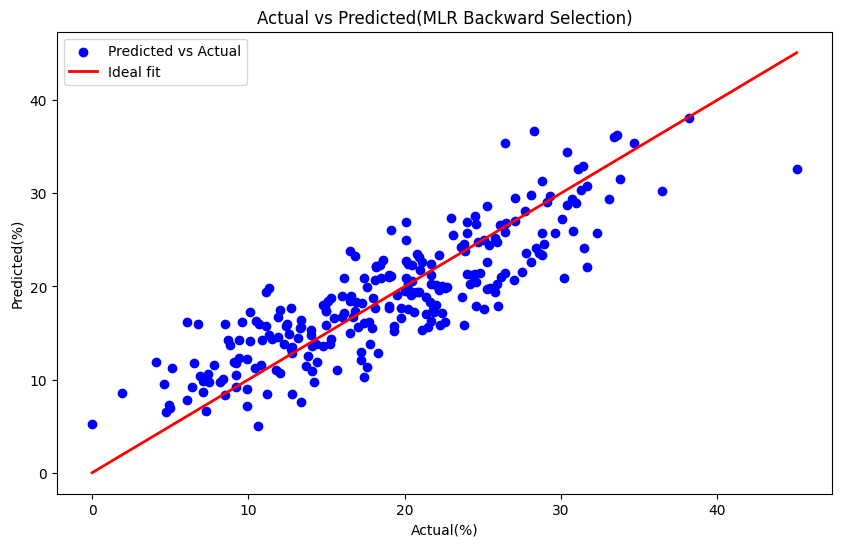

Mean Squared Error: 15.648020007466874


In [294]:
model = LinearRegression()

model.fit(X_backward,y)

y_pred = model.predict(X_selected)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Ideal fit')
plt.xlabel('Actual(%)')
plt.ylabel('Predicted(%)')
plt.title('Actual vs Predicted(MLR Backward Selection)')
plt.legend()

plt.show()


print("Mean Squared Error:", mean_squared_error(y, y_pred))

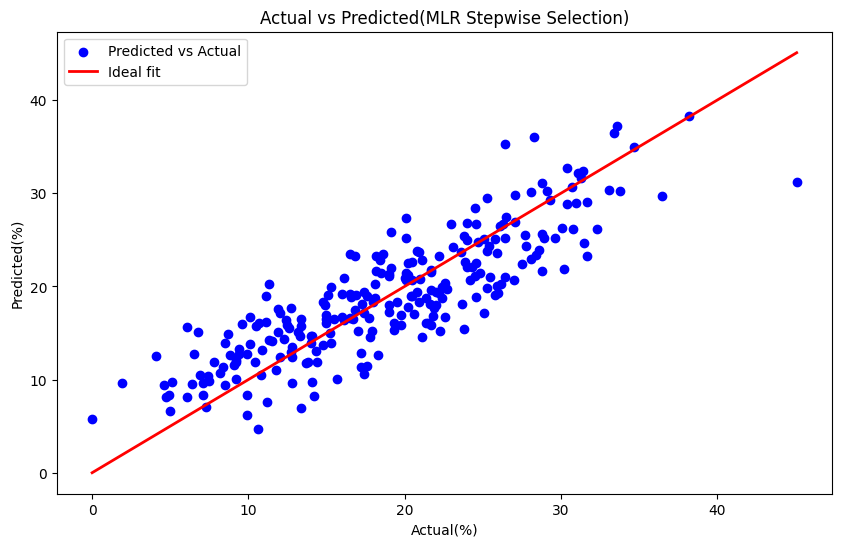

Mean Squared Error: 15.981289607849414


In [295]:
model = LinearRegression()

model.fit(X_stepwise,y)

y_pred = model.predict(X_stepwise)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Ideal fit')
plt.xlabel('Actual(%)')
plt.ylabel('Predicted(%)')
plt.title('Actual vs Predicted(MLR Stepwise Selection)')
plt.legend()

plt.show()


print("Mean Squared Error:", mean_squared_error(y, y_pred))

In [296]:
X_with_const = sm.add_constant(X_selected)  
ols_model = sm.OLS(y, X_with_const)
results = ols_model.fit()


print("forward:",results.summary())

forward:                             OLS Regression Results                            
Dep. Variable:                BODYFAT   R-squared:                       0.738
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     98.44
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           2.08e-67
Time:                        15:30:26   Log-Likelihood:                -704.12
No. Observations:                 252   AIC:                             1424.
Df Residuals:                     244   BIC:                             1452.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.9890      0.968      5.156

In [297]:
X_with_const = sm.add_constant(X_stepwise)  
ols_model = sm.OLS(y, X_with_const)
results = ols_model.fit()


print("stepwise:",results.summary())

stepwise:                             OLS Regression Results                            
Dep. Variable:                BODYFAT   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     169.5
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           1.42e-69
Time:                        15:30:26   Log-Likelihood:                -706.77
No. Observations:                 252   AIC:                             1424.
Df Residuals:                     247   BIC:                             1441.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.8506      0.967      7.08

## Decision Tree

In [298]:
from sklearn.tree import DecisionTreeRegressor, plot_tree ,export_text

X = df_imputed_scaled.drop(columns=["IDNO","BODYFAT","DENSITY"])
y = df_imputed["BODYFAT"]

tree_model = DecisionTreeRegressor(max_depth=5)
tree_model.fit(X, y)

importances = tree_model.feature_importances_

In [299]:
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(X.shape[1])]
# for feature, importance in zip(feature_names, importances):
#     print(f"{feature}: {importance}")

In [300]:
feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, importances)}


sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))


print("Sorted feature importance:")
for feature, importance in sorted_feature_importance.items():
    print(f"{feature}: {importance}")

Sorted feature importance:
ABDOMEN: 0.8136908803297368
WRIST: 0.0331098345115108
KNEE: 0.029537817713934912
WEIGHT: 0.02948478024230536
HEIGHT: 0.02732744530526205
THIGH: 0.022239210555526814
HIP: 0.01338275131170551
FOREARM: 0.011222449442724436
AGE: 0.007650777930557911
ADIPOSITY: 0.005434350881412627
CHEST: 0.004758955173089234
ANKLE: 0.00216074660223356
NECK: 0.0
BICEPS: 0.0


In [301]:
y_pred = tree_model.predict(X)

mse = mean_squared_error(y, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 8.901490266580414


In [235]:
tree_rules = export_text(tree_model, feature_names=list(X.columns))
print(tree_rules)

|--- ABDOMEN <= 0.46
|   |--- ABDOMEN <= 0.33
|   |   |--- ABDOMEN <= 0.13
|   |   |   |--- THIGH <= 0.16
|   |   |   |   |--- THIGH <= 0.12
|   |   |   |   |   |--- value: [0.95]
|   |   |   |   |--- THIGH >  0.12
|   |   |   |   |   |--- value: [4.85]
|   |   |   |--- THIGH >  0.16
|   |   |   |   |--- CHEST <= 0.22
|   |   |   |   |   |--- value: [10.90]
|   |   |   |   |--- CHEST >  0.22
|   |   |   |   |   |--- value: [8.50]
|   |   |--- ABDOMEN >  0.13
|   |   |   |--- WRIST <= 0.36
|   |   |   |   |--- HIP <= 0.27
|   |   |   |   |   |--- value: [10.85]
|   |   |   |   |--- HIP >  0.27
|   |   |   |   |   |--- value: [14.59]
|   |   |   |--- WRIST >  0.36
|   |   |   |   |--- AGE <= 0.63
|   |   |   |   |   |--- value: [9.14]
|   |   |   |   |--- AGE >  0.63
|   |   |   |   |   |--- value: [14.45]
|   |--- ABDOMEN >  0.33
|   |   |--- WEIGHT <= 0.42
|   |   |   |--- THIGH <= 0.30
|   |   |   |   |--- THIGH <= 0.26
|   |   |   |   |   |--- value: [10.90]
|   |   |   |   |--- THIG

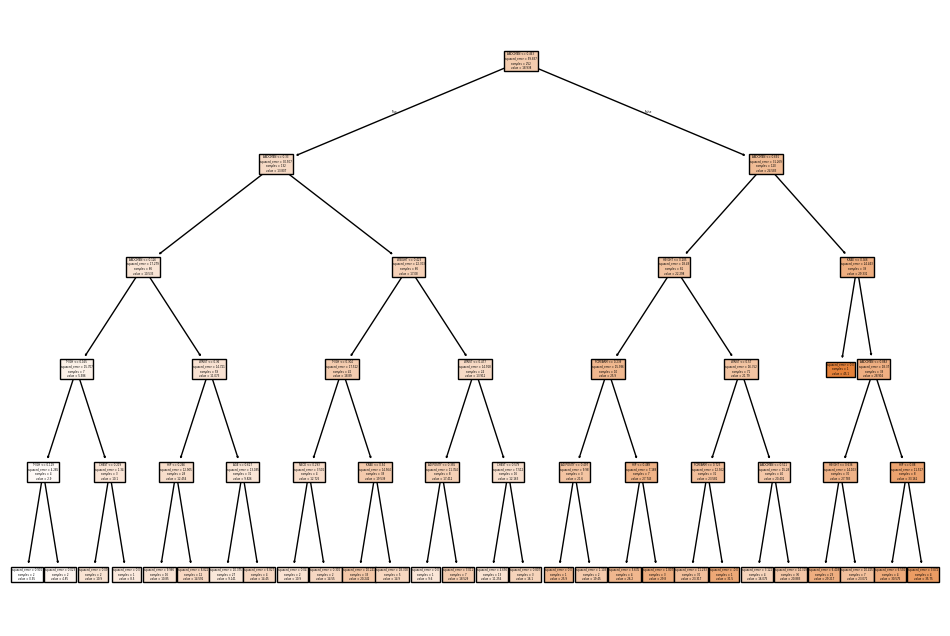

In [232]:
# plt.figure(figsize=(12, 8))


# plot_tree(tree_model, feature_names=X.columns, class_names=True, filled=True)


# plt.show()